[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github.com/tulasiram58827/ocr_tflite/blob/main/colabs/KERAS_OCR_TFLITE.ipynb)

## SetUp

In [1]:
!pip install validators

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=dbdc880754443becfa23492da3f07815be3fde0af395740dc6ab63eb5f747c33
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [2]:
import typing
import string

import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import hashlib

import urllib.request
import urllib.parse

tf.__version__

'2.8.2'

### Hyper-Parameters

In [3]:
DEFAULT_BUILD_PARAMS = {
    'height': 31,
    'width': 200,
    'color': False,
    'filters': (64, 128, 256, 256, 512, 512, 512),
    'rnn_units': (128, 128),
    'dropout': 0.25,
    'rnn_steps_to_discard': 2,
    'pool_size': 2,
    'stn': True,
}

DEFAULT_ALPHABET = string.digits + string.ascii_lowercase

PRETRAINED_WEIGHTS = {
    'kurapan': {
        'alphabet': DEFAULT_ALPHABET,
        'build_params': DEFAULT_BUILD_PARAMS,
        'weights': {
            'notop': {
                'url':
                'https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/crnn_kurapan_notop.h5',
                'filename': 'crnn_kurapan_notop.h5',
                'sha256': '027fd2cced3cbea0c4f5894bb8e9e85bac04f11daf96b8fdcf1e4ee95dcf51b9'
            },
            'top': {
                'url':
                'https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/crnn_kurapan.h5',
                'filename': 'crnn_kurapan.h5',
                'sha256': 'a7d8086ac8f5c3d6a0a828f7d6fbabcaf815415dd125c32533013f85603be46d'
            }
        }
    }
}

## Utilities

In [4]:
def swish(x, beta=1):
    return x * keras.backend.sigmoid(beta * x)


keras.utils.get_custom_objects().update({'swish': keras.layers.Activation(swish)})


def _repeat(x, num_repeats):
    ones = tf.ones((1, num_repeats), dtype='int32')
    x = tf.reshape(x, shape=(-1, 1))
    x = tf.matmul(x, ones)
    return tf.reshape(x, [-1])


def _meshgrid(height, width):
    x_linspace = tf.linspace(-1., 1., width)
    y_linspace = tf.linspace(-1., 1., height)
    x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
    x_coordinates = tf.reshape(x_coordinates, shape=(1, -1))
    y_coordinates = tf.reshape(y_coordinates, shape=(1, -1))
    ones = tf.ones_like(x_coordinates)
    indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
    return indices_grid


# pylint: disable=too-many-statements
def _transform(inputs):
    locnet_x, locnet_y = inputs
    output_size = locnet_x.shape[1:]
    batch_size = tf.shape(locnet_x)[0]
    height = tf.shape(locnet_x)[1]
    width = tf.shape(locnet_x)[2]
    num_channels = tf.shape(locnet_x)[3]

    locnet_y = tf.reshape(locnet_y, shape=(batch_size, 2, 3))

    locnet_y = tf.reshape(locnet_y, (-1, 2, 3))
    locnet_y = tf.cast(locnet_y, 'float32')

    output_height = output_size[0]
    output_width = output_size[1]
    indices_grid = _meshgrid(output_height, output_width)
    indices_grid = tf.expand_dims(indices_grid, 0)
    indices_grid = tf.reshape(indices_grid, [-1])  # flatten?
    indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
    indices_grid = tf.reshape(indices_grid, tf.stack([batch_size, 3, -1]))

    transformed_grid = tf.matmul(locnet_y, indices_grid)
    x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
    y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
    x = tf.reshape(x_s, [-1])
    y = tf.reshape(y_s, [-1])

    # Interpolate
    height_float = tf.cast(height, dtype='float32')
    width_float = tf.cast(width, dtype='float32')

    output_height = output_size[0]
    output_width = output_size[1]

    x = tf.cast(x, dtype='float32')
    y = tf.cast(y, dtype='float32')
    x = .5 * (x + 1.0) * width_float
    y = .5 * (y + 1.0) * height_float

    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    max_y = tf.cast(height - 1, dtype='int32')
    max_x = tf.cast(width - 1, dtype='int32')
    zero = tf.zeros([], dtype='int32')

    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    flat_image_dimensions = width * height
    pixels_batch = tf.range(batch_size) * flat_image_dimensions
    flat_output_dimensions = output_height * output_width
    base = _repeat(pixels_batch, flat_output_dimensions)
    base_y0 = base + y0 * width
    base_y1 = base + y1 * width
    indices_a = base_y0 + x0
    indices_b = base_y1 + x0
    indices_c = base_y0 + x1
    indices_d = base_y1 + x1

    flat_image = tf.reshape(locnet_x, shape=(-1, num_channels))
    flat_image = tf.cast(flat_image, dtype='float32')
    pixel_values_a = tf.gather(flat_image, indices_a)
    pixel_values_b = tf.gather(flat_image, indices_b)
    pixel_values_c = tf.gather(flat_image, indices_c)
    pixel_values_d = tf.gather(flat_image, indices_d)

    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
    area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
    area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
    area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
    transformed_image = tf.add_n([
        area_a * pixel_values_a, area_b * pixel_values_b, area_c * pixel_values_c,
        area_d * pixel_values_d
    ])
    # Finished interpolation

    transformed_image = tf.reshape(transformed_image,
                                   shape=(batch_size, output_height, output_width, num_channels))
    return transformed_image

## Create Model

In [5]:
def CTCDecoder():
    def decoder(y_pred):
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(
            input_shape[1], 'float32')
        unpadded = tf.keras.backend.ctc_decode(y_pred, input_length)[0][0]
        unpadded_shape = tf.keras.backend.shape(unpadded)
        padded = tf.pad(unpadded,
                        paddings=[[0, 0], [0, input_shape[1] - unpadded_shape[1]]],
                        constant_values=-1)
        return padded

    return tf.keras.layers.Lambda(decoder, name='decode')

In [6]:
def build_model(alphabet,
                height,
                width,
                color,
                filters,
                rnn_units,
                dropout,
                rnn_steps_to_discard,
                pool_size,
                stn=True):
    """Build a Keras CRNN model for character recognition.
    Args:
        height: The height of cropped images
        width: The width of cropped images
        color: Whether the inputs should be in color (RGB)
        filters: The number of filters to use for each of the 7 convolutional layers
        rnn_units: The number of units for each of the RNN layers
        dropout: The dropout to use for the final layer
        rnn_steps_to_discard: The number of initial RNN steps to discard
        pool_size: The size of the pooling steps
        stn: Whether to add a Spatial Transformer layer
    """
    assert len(filters) == 7, '7 CNN filters must be provided.'
    assert len(rnn_units) == 2, '2 RNN filters must be provided.'
    inputs = keras.layers.Input((height, width, 3 if color else 1), name='input', batch_size=1)
    x = keras.layers.Permute((2, 1, 3))(inputs)
    x = keras.layers.Lambda(lambda x: x[:, :, ::-1])(x)
    x = keras.layers.Conv2D(filters[0], (3, 3), activation='relu', padding='same', name='conv_1')(x)
    x = keras.layers.Conv2D(filters[1], (3, 3), activation='relu', padding='same', name='conv_2')(x)
    x = keras.layers.Conv2D(filters[2], (3, 3), activation='relu', padding='same', name='conv_3')(x)
    x = keras.layers.BatchNormalization(name='bn_3')(x)
    x = keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), name='maxpool_3')(x)
    x = keras.layers.Conv2D(filters[3], (3, 3), activation='relu', padding='same', name='conv_4')(x)
    x = keras.layers.Conv2D(filters[4], (3, 3), activation='relu', padding='same', name='conv_5')(x)
    x = keras.layers.BatchNormalization(name='bn_5')(x)
    x = keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), name='maxpool_5')(x)
    x = keras.layers.Conv2D(filters[5], (3, 3), activation='relu', padding='same', name='conv_6')(x)
    x = keras.layers.Conv2D(filters[6], (3, 3), activation='relu', padding='same', name='conv_7')(x)
    x = keras.layers.BatchNormalization(name='bn_7')(x)
    if stn:
        # pylint: disable=pointless-string-statement
        """Spatial Transformer Layer
        Implements a spatial transformer layer as described in [1]_.
        Borrowed from [2]_:
        downsample_fator : float
            A value of 1 will keep the orignal size of the image.
            Values larger than 1 will down sample the image. Values below 1 will
            upsample the image.
            example image: height= 100, width = 200
            downsample_factor = 2
            output image will then be 50, 100
        References
        ----------
        .. [1]  Spatial Transformer Networks
                Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
                Submitted on 5 Jun 2015
        .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
        .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
        """
        stn_input_output_shape = (width // pool_size**2, height // pool_size**2, filters[6])
        stn_input_layer = keras.layers.Input(shape=stn_input_output_shape)
        locnet_y = keras.layers.Conv2D(16, (5, 5), padding='same',
                                       activation='relu')(stn_input_layer)
        locnet_y = keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')(locnet_y)
        locnet_y = keras.layers.Flatten()(locnet_y)
        locnet_y = keras.layers.Dense(64, activation='relu')(locnet_y)
        locnet_y = keras.layers.Dense(6,
                                      weights=[
                                          np.zeros((64, 6), dtype='float32'),
                                          np.float32([[1, 0, 0], [0, 1, 0]]).flatten()
                                      ])(locnet_y)
        localization_net = keras.models.Model(inputs=stn_input_layer, outputs=locnet_y)
        x = keras.layers.Lambda(_transform,
                                output_shape=stn_input_output_shape)([x, localization_net(x)])
    x = keras.layers.Reshape(target_shape=(width // pool_size**2,
                                           (height // pool_size**2) * filters[-1]),
                             name='reshape')(x)

    x = keras.layers.Dense(rnn_units[0], activation='relu', name='fc_9')(x)

    rnn_1_forward = keras.layers.LSTM(rnn_units[0],
                                      kernel_initializer="he_normal",
                                      return_sequences=True,
                                      name='lstm_10')(x)
    rnn_1_back = keras.layers.LSTM(rnn_units[0],
                                   kernel_initializer="he_normal",
                                   go_backwards=True,
                                   return_sequences=True,
                                   name='lstm_10_back')(x)
    rnn_1_add = keras.layers.Add()([rnn_1_forward, rnn_1_back])
    rnn_2_forward = keras.layers.LSTM(rnn_units[1],
                                      kernel_initializer="he_normal",
                                      return_sequences=True,
                                      name='lstm_11')(rnn_1_add)
    rnn_2_back = keras.layers.LSTM(rnn_units[1],
                                   kernel_initializer="he_normal",
                                   go_backwards=True,
                                   return_sequences=True,
                                   name='lstm_11_back')(rnn_1_add)
    x = keras.layers.Concatenate()([rnn_2_forward, rnn_2_back])
    backbone = keras.models.Model(inputs=inputs, outputs=x)
    x = keras.layers.Dropout(dropout, name='dropout')(x)
    x = keras.layers.Dense(len(alphabet) + 1,
                           kernel_initializer='he_normal',
                           activation='softmax',
                           name='fc_12')(x)
    x = keras.layers.Lambda(lambda x: x[:, rnn_steps_to_discard:])(x)
    model = keras.models.Model(inputs=inputs, outputs=x)
    prediction_model = keras.models.Model(inputs=inputs, outputs=CTCDecoder()(model.output))
    return model, prediction_model

In [7]:
build_params = DEFAULT_BUILD_PARAMS
alphabets = DEFAULT_ALPHABET
blank_index = len(alphabets)

model, prediction_model = build_model(alphabet=alphabets, **build_params)

## Download and Load Weights

In [8]:
def get_default_cache_dir():
    return os.environ.get('KERAS_OCR_CACHE_DIR', os.path.expanduser(os.path.join('~',
                                                                              '.keras-ocr')))
def sha256sum(filename):
    """Compute the sha256 hash for a file."""
    h = hashlib.sha256()
    b = bytearray(128 * 1024)
    mv = memoryview(b)
    with open(filename, 'rb', buffering=0) as f:
        for n in iter(lambda: f.readinto(mv), 0):
            h.update(mv[:n])
    return h.hexdigest()

def download_and_verify(url, sha256=None, cache_dir=None, verbose=True, filename=None):
    """Download a file to a cache directory and verify it with a sha256
    hash.
    Args:
        url: The file to download
        sha256: The sha256 hash to check. If the file already exists and the hash
            matches, we don't download it again.
        cache_dir: The directory in which to cache the file. The default is
            `~/.keras-ocr`.
        verbose: Whether to log progress
        filename: The filename to use for the file. By default, the filename is
            derived from the URL.
    """
    if cache_dir is None:
        cache_dir = get_default_cache_dir()
    if filename is None:
        filename = os.path.basename(urllib.parse.urlparse(url).path)
    filepath = os.path.join(cache_dir, filename)
    os.makedirs(os.path.split(filepath)[0], exist_ok=True)
    if verbose:
        print('Looking for ' + filepath)
    if not os.path.isfile(filepath) or (sha256 and sha256sum(filepath) != sha256):
        if verbose:
            print('Downloading ' + filepath)
        urllib.request.urlretrieve(url, filepath)
    assert sha256 is None or sha256 == sha256sum(filepath), 'Error occurred verifying sha256.'
    return filepath

In [9]:
weights_dict = PRETRAINED_WEIGHTS['kurapan']

model.load_weights(download_and_verify(url=weights_dict['weights']['top']['url'],
                                       filename=weights_dict['weights']['top']['filename'],
                                       sha256=weights_dict['weights']['top']['sha256']))

Looking for /root/.keras-ocr/crnn_kurapan.h5


## Model Architecture

In [10]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(1, 31, 200, 1)]    0           []                               
                                                                                                  
 permute (Permute)              (1, 200, 31, 1)      0           ['input[0][0]']                  
                                                                                                  
 lambda (Lambda)                (1, 200, 31, 1)      0           ['permute[0][0]']                
                                                                                                  
 conv_1 (Conv2D)                (1, 200, 31, 64)     640         ['lambda[0][0]']                 
                                                                                            

## Convert to TFLite

In [11]:
# Download and unzipping representative dataset
%%bash
wget https://github.com/tulasiram58827/ocr_tflite/raw/main/data/represent_data.zip
unzip represent_data.zip

Archive:  represent_data.zip
   creating: represent_data/
  inflating: represent_data/word_1.png  
  inflating: represent_data/word_2.png  
  inflating: represent_data/word_3.png  
  inflating: represent_data/word_4.png  
  inflating: represent_data/word_5.png  
  inflating: represent_data/word_6.png  
  inflating: represent_data/word_7.png  
  inflating: represent_data/word_8.png  
  inflating: represent_data/word_9.png  
  inflating: represent_data/word_10.png  
  inflating: represent_data/word_11.png  
  inflating: represent_data/word_12.png  
  inflating: represent_data/word_13.png  
  inflating: represent_data/word_14.png  
  inflating: represent_data/word_15.png  
  inflating: represent_data/word_16.png  
  inflating: represent_data/word_17.png  
  inflating: represent_data/word_18.png  
  inflating: represent_data/word_19.png  
  inflating: represent_data/word_20.png  
  inflating: represent_data/word_21.png  
  inflating: represent_data/word_22.png  
  inflating: represent_data

--2022-09-09 22:36:49--  https://github.com/tulasiram58827/ocr_tflite/raw/main/data/represent_data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tulasiram58827/ocr_tflite/main/data/represent_data.zip [following]
--2022-09-09 22:36:50--  https://raw.githubusercontent.com/tulasiram58827/ocr_tflite/main/data/represent_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585568 (572K) [application/zip]
Saving to: ‘represent_data.zip’

     0K .......... .......... .......... .......... ..........  8% 50.5M 0s
    50K .......... .......... .......... .......... .......... 17% 34.4M 0s
   10

In [12]:
dataset_path = '/content/represent_data/'
def representative_data_gen():
    for file in os.listdir(dataset_path):
        image_path = dataset_path + file
        input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        input_data = cv2.resize(input_data, (200, 31))
        input_data = input_data[np.newaxis]
        input_data = np.expand_dims(input_data, 3)
        input_data = input_data.astype('float32')/255
        yield [input_data]

In [14]:
def convert_tflite(quantization):
    converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
    if quantization == 'float16':
        converter.target_spec.supported_types = [tf.float16]
    elif quantization == 'int8' or quantization == 'full_int8':
        converter.representative_dataset = representative_data_gen
    if quantization == 'full_int8':
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8  # or tf.uint8
        converter.inference_output_type = tf.int8  # or tf.uint8
    tf_lite_model = converter.convert()
    open(f'ocr_{quantization}.tflite', 'wb').write(tf_lite_model)

**Note** : Support for CTC Decoder is not available in TFLite yet. So while converting we removed CTCDecoder in model part. We need to run Decoder from the output of the model. 

Refer to this [issue](https://github.com/tensorflow/tensorflow/issues/33494) regarding CTC decoder support in TFLite. 

**Update** : CTC Decoder is supported in TFLite now by enabling Built-in-Ops in Tensorflow 2.4. Thanks to TensorFlow team for the support.

In [15]:
quantization = 'dr' #@param ["dr", "float16"]
convert_tflite(quantization)

In [16]:
!du -sh ocr_dr.tflite

8.5M	ocr_dr.tflite


In [17]:
quantization = 'float16' #@param ["dr", "float16"]
convert_tflite(quantization)

In [18]:
!du -sh ocr_float16.tflite

17M	ocr_float16.tflite


In [19]:
quantization = 'int8'  #@param ["dr", "float16", 'int8', 'full_int8']
convert_tflite(quantization)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


**Currently Integer Quantization is erroring out and informed to TFLite team**

## TFLite Inference

In [20]:
def run_tflite_model(image_path, quantization):
    input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    input_data = cv2.resize(input_data, (200, 31))
    input_data = input_data[np.newaxis]
    input_data = np.expand_dims(input_data, 3)
    input_data = input_data.astype('float32')/255
    path = f'ocr_{quantization}.tflite'
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    return output

In [25]:
from google.colab.patches import cv2_imshow
image_path = './hello2.png'

helo


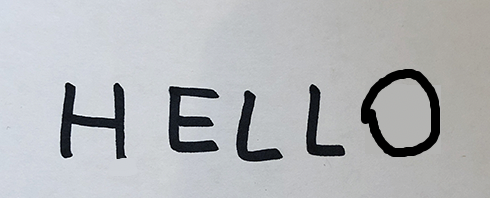

In [26]:
# Running Dynamic Range Quantization
tflite_output = run_tflite_model(image_path, 'dr')
final_output = "".join(alphabets[index] for index in tflite_output[0] if index not in [blank_index, -1])
print(final_output)
cv2_imshow(cv2.imread(image_path))

hello


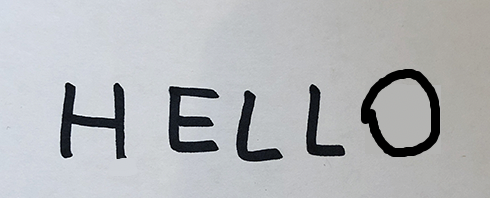

In [27]:
# Running Float16 Quantization
tflite_output = run_tflite_model(image_path, 'float16')
final_output = "".join(alphabets[index] for index in tflite_output[0] if index not in [blank_index, -1])
print(final_output)
cv2_imshow(cv2.imread(image_path))

In [29]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import argparse
import imutils
import cv2



text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


In [ ]:



with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))


strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)



random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]


train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)




class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

embed_dim = 256
latent_dim = 2048
num_heads = 8

vocab_size = 15000
sequence_length = 20

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

transformer.load_weights("./transformer")



strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)


spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence



input_sentence = final_output
#print(type(input_sentence))
translated = decode_sequence(input_sentence)
print(translated)

In [28]:
# Running Integer Quantization
tflite_output = run_tflite_model(image_path, 'int8')
final_output = "".join(alphabets[index] for index in decoded[0] if index not in [blank_index, -1])
print(final_output)
cv2_imshow(cv2.imread(image_path))

NameError: ignored

**The above code snippet will error out as informed integer quantization is not yet supported**

## Dynamic Range Model benchmarks

**Inference Time** : 0.2sec

**Memory FootPrint** : 46.38MB

**Model Size** : 8.5MB

## Float16 benchmarks

**Inference** : 0.76sec

**Memory FootPrint** : 128MB

**Model Size** : 17MB

**The above benchmarks with respect to Redmi K20 Pro with 4 threads. **